In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
from sklearn.base import clone
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_columns', 500)

# Data

[dataset](https://users.nber.org/~rdehejia/nswdata2.html)

In [7]:
# Randomized Control Trial - Lalonde dataset
rct_ctl = pd.read_csv('/Users/S/Desktop/projects/datasets/lalonde/nsw_control.txt', sep=' ', header=None)
rct_ctl = rct_ctl.dropna(axis=1)
rct_ctl.columns = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're75', 're78']

rct_trt = pd.read_csv('/Users/S/Desktop/projects/datasets/lalonde/nsw_treated.txt', sep=' ', header=None)
rct_trt = rct_trt.dropna(axis=1)
rct_trt.columns = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're75', 're78']

rct_df = pd.concat([rct_ctl, rct_trt]).reset_index(drop=True)
rct_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re75,re78
0,0.0,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.00
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,12383.68
2,0.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.00


In [8]:
# Controls from PSID
psid_ctl_1 = pd.read_csv('/Users/S/Desktop/projects/datasets/psid/psid_controls.txt', sep=' ', header=None)
psid_ctl_1 = psid_ctl_1.dropna(axis=1)
psid_ctl_1.columns = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']

psid_ctl_2 = pd.read_csv('/Users/S/Desktop/projects/datasets/psid/psid2_controls.txt', sep=' ', header=None)
psid_ctl_2 = psid_ctl_2.dropna(axis=1)
psid_ctl_2.columns = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']

psid_ctl_3 = pd.read_csv('/Users/S/Desktop/projects/datasets/psid/psid3_controls.txt', sep=' ', header=None)
psid_ctl_3 = psid_ctl_3.dropna(axis=1)
psid_ctl_3.columns = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']

psid_ctl = pd.concat([psid_ctl_1, psid_ctl_2, psid_ctl_3]).reset_index(drop=True)

In [9]:
# Combine treatment from rct and controls from psid to general observational data
obs_df = pd.concat([
    psid_ctl[['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're75', 're78']], 
    rct_trt])
obs_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re75,re78
0,0.0,47.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,50.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,44.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0


# RCT Dataset

treat
0.0           NaN
1.0    886.303731
Name: re78, dtype: float64


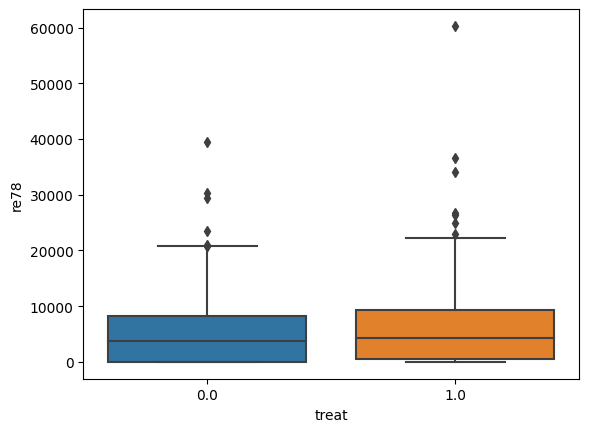

In [10]:
sns.boxplot(rct_df, x='treat', y='re78')

print(rct_df.groupby('treat')['re78'].mean().diff())

In [11]:
# formula = 're78 ~ treat + age + educ + black + hispan + married + nodegree + re75'
formula = 're78 ~ treat'
rct_model = smf.ols(formula, data=rct_df).fit()
rct_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.525
Date:                Sat, 13 May 2023   Prob (F-statistic):             0.0609
Time:                        21:27:03   Log-Likelihood:                -7333.1
No. Observations:                 722   AIC:                         1.467e+04
Df Residuals:                     720   BIC:                         1.468e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5090.0483    302.783     16.811      0.000    4495.606    5684.491
treat        886.3037    472.086      1.877      0.061     -40.526    1813.134
==============================================================================
Omnibus:                      384.449   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3767.287
Skew:                           2.195   Prob(JB):                         0.00
Kurtosis:                      13.294   Cond. No.                         2.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The treatment effect is $886 with a p-value = 0.06 which is > 0.05, so not statistically significant.

# Observational Dataset

treat
0.0             NaN
1.0   -13833.466224
Name: re78, dtype: float64


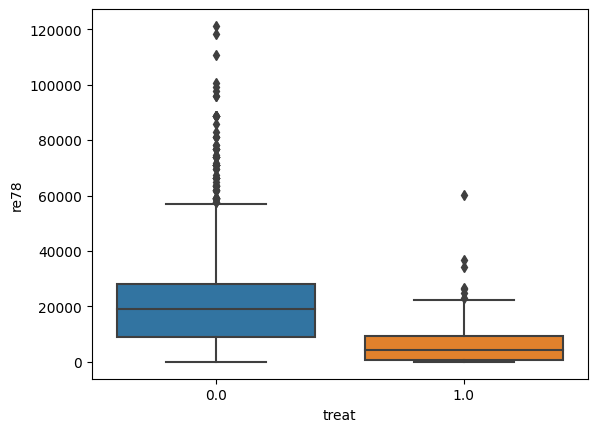

In [12]:
sns.boxplot(obs_df, x='treat', y='re78')

print(obs_df.groupby('treat')['re78'].mean().diff())

The control dataset (PSID) from now is biased in comparison to the treatment. The re78 from control is on average higher than treatment in the observational dataset.  If we estimated the ATE by difference of means, we would have a negative result: -$15,577.

In [13]:
obs_df['treat'].value_counts()

treat
0.0    2871
1.0     297
Name: count, dtype: int64

## A. OLS

First run an OLS regressing on pre-experiment covariates.

In [14]:
formula = 're78 ~ treat'
obs_ols = smf.ols(formula, data=obs_df).fit()
obs_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     228.2
Date:                Sat, 13 May 2023   Prob (F-statistic):           7.71e-50
Time:                        21:27:09   Log-Likelihood:                -34962.
No. Observations:                3168   AIC:                         6.993e+04
Df Residuals:                    3166   BIC:                         6.994e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.981e+04    280.387     70.652      0.000    1.93e+04    2.04e+04
treat      -1.383e+04    915.739    -15.106      0.000   -1.56e+04    -1.2e+04
==============================================================================
Omnibus:                      833.651   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3042.229
Skew:                           1.272   Prob(JB):                         0.00
Kurtosis:                       7.071   Cond. No.                         3.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The treatment effect is wrongly estimated in the observational dataset and suggests that training programs decreases an individual's income.

In [15]:
formula = 're78 ~ treat + age + educ + black + hispan + married + nodegree + re75'
obs_ols = smf.ols(formula, data=obs_df).fit()
obs_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     573.5
Date:                Sat, 13 May 2023   Prob (F-statistic):               0.00
Time:                        21:27:11   Log-Likelihood:                -33651.
No. Observations:                3168   AIC:                         6.732e+04
Df Residuals:                    3159   BIC:                         6.738e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -165.4251   1543.480     -0.107      0.915   -3191.749    2860.899
treat      -1036.3091    740.197     -1.400      0.162   -2487.625     415.006
age          -76.2741     18.476     -4.128      0.000    -112.499     -40.049
educ         628.7012     94.209      6.673      0.000     443.984     813.419
black       -721.5647    445.965     -1.618      0.106   -1595.975     152.845
hispan      1243.2887    889.742      1.397      0.162    -501.241    2987.819
married     1864.4523    509.711      3.658      0.000     865.054    2863.850
nodegree     366.7269    578.576      0.634      0.526    -767.696    1501.150
re75           0.7858      0.015     53.056      0.000       0.757       0.815
==============================================================================
Omnibus:                     1130.383   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24229.843
Skew:                           1.172   Prob(JB):                         0.00
Kurtosis:                      16.344   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Controlling for the covariates still results in a treatment effect estimated in the wrong direction still.

# B. Linear Double ML - ATE 

In [16]:
y = "re78"
d = "treat"
X = ["age", "educ", "black", "hispan", "married", "nodegree", "re75"]

# Machine learning models
debias_m = LGBMClassifier(max_depth=3, objective='binary')
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
obs_dml_pred = obs_df.assign(
    d_res =  obs_df[d] - cross_val_predict(debias_m, obs_df[X], obs_df[d], cv=5),
    y_res =  obs_df[y] - cross_val_predict(denoise_m, obs_df[X], obs_df[y], cv=5)
)

# Predict the average treatment effect 
obs_dml_model = smf.ols(formula='y_res ~ d_res', data=obs_dml_pred).fit()
obs_dml_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_res   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.96
Date:                Sat, 13 May 2023   Prob (F-statistic):           3.92e-05
Time:                        21:27:13   Log-Likelihood:                -33952.
No. Observations:                3168   AIC:                         6.791e+04
Df Residuals:                    3166   BIC:                         6.792e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1055.1468    194.159      5.434      0.000     674.456    1435.838
d_res      -3083.4822    748.792     -4.118      0.000   -4551.648   -1615.316
==============================================================================
Omnibus:                     1324.629   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18141.996
Skew:                           1.606   Prob(JB):                         0.00
Kurtosis:                      14.275   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Bias
obs_dml_model.params['d_res'] - rct_model.params['treat']

-3969.785968346412

# C. Double ML library

In [29]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

In [30]:
dml_data_obj = DoubleMLData(obs_df, y_col=y, d_cols=d, x_cols=X)

In [31]:
ml_g = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
ml_m = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=3, min_samples_leaf=3)

dml_plr = DoubleMLPLR(dml_data_obj, ml_g, ml_m, n_folds=3)
dml_plr.fit(store_predictions=True)
print(dml_plr)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're75']
Instrument variable(s): None
No. Observations: 3168

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=7, max_features=3, min_samples_leaf=3,
                      n_estimators=500)
Learner ml_m: RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=3,
                       n_estimators=500)
Out-of-sample Performance:
Learner ml_l RMSE: [[9878.59283458]]
Learner ml_m RMSE: [[0.20340558]]

------------------ Resampling        ------------------
No. folds: 3
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
 

In [35]:
# Bias
dml_plr.coef - rct_model.params['treat']

array([-3614.29806093])